## Causal Skeleton Discovery Using Mutual Information

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import leap
import numpy as np
import scipy
from leap.datasets.sim_dataset import SimulationDatasetTSTwoSampleNS
from leap.modules.srnn_ns import SRNNSyntheticNS
from leap.modules.metrics.correlation import correlation
import random
import seaborn as sns
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from leap.tools.utils import load_yaml
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import ipdb as pdb

In [4]:
use_cuda = True
device = torch.device("cuda:0" if use_cuda else "cpu")
latent_size = 8

In [222]:
data = SimulationDatasetTSTwoSampleNS(directory = '/srv/data/ltcl/data', 
                         transition='nonlinear_gau_cins_sparse')
num_validation_samples = 2500
train_data, val_data = random_split(data, [len(data)-num_validation_samples, num_validation_samples])
train_loader = DataLoader(train_data, batch_size=2560, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_data, batch_size=16, shuffle=False, pin_memory=True)

In [170]:
cfg = load_yaml('../leap/configs/toy_nonlinear_gau_ns.yaml')

In [209]:
model =  SRNNSyntheticNS.load_from_checkpoint(  checkpoint_path="/srv/data/ltcl/log/weiran/toy_nonlinear_gau_ns/lightning_logs/version_67/checkpoints/epoch=28-step=133157.ckpt",
                                                input_dim=cfg['VAE']['INPUT_DIM'],
                                                length=cfg['VAE']['LENGTH'],
                                                z_dim=cfg['VAE']['LATENT_DIM'], 
                                                lag=cfg['VAE']['LAG'],
                                                nclass=cfg['VAE']['NCLASS'],
                                                hidden_dim=cfg['VAE']['ENC']['HIDDEN_DIM'],
                                                trans_prior=cfg['VAE']['TRANS_PRIOR'],
                                                bound=cfg['SPLINE']['BOUND'],
                                                count_bins=cfg['SPLINE']['BINS'],
                                                order=cfg['SPLINE']['ORDER'],
                                                beta=cfg['VAE']['BETA'],
                                                gamma=cfg['VAE']['GAMMA'],
                                                sigma=cfg['VAE']['SIGMA'],
                                                lr=cfg['VAE']['LR'],
                                                bias=cfg['VAE']['BIAS'],
                                                use_warm_start=cfg['SPLINE']['USE_WARM_START'],
                                                spline_pth=cfg['SPLINE']['PATH'],
                                                decoder_dist=cfg['VAE']['DEC']['DIST'],
                                                correlation=cfg['MCC']['CORR'])

Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow


In [243]:
batch = next(iter(train_loader))
batch_size = batch['s1']['xt'].shape[0]

In [244]:
from leap.modules.metrics.correlation import correlation

In [245]:
z, mu, logvar = model.forward(batch['s1'])
mu = mu.view(batch_size, -1, latent_size)
A = mu[:,2,:].detach().cpu().numpy()
B = batch['s1']['yt'][:,2,:].detach().cpu().numpy()
C = np.zeros((latent_size,latent_size))
for i in range(latent_size):
    C[i] = -np.abs(np.corrcoef(B, A, rowvar=False)[i,latent_size:])
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(C)
A = A[:, col_ind]
mask = np.ones(latent_size)
for i in range(latent_size):
    if np.corrcoef(B, A, rowvar=False)[i,latent_size:][i] > 0:
        mask[i] = -1
print("Permutation:",col_ind)
print("Sign Flip:", mask)

Permutation: [0 1 3 6 4 2 7 5]
Sign Flip: [-1.  1.  1. -1. -1.  1. -1. -1.]


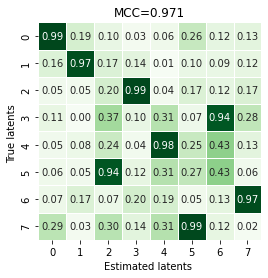

In [247]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages(figure_path + '/mcc_np.pdf') as pdf:
    fig = plt.figure(figsize=(4,4))
    sns.heatmap(-C, vmin=0, vmax=1, annot=True, fmt=".2f", linewidths=.5, cbar=False, cmap='Greens')
    plt.xlabel("Estimated latents ") 
    plt.ylabel("True latents ") 
    plt.title("MCC=%.3f"%np.abs(C[row_ind, col_ind]).mean());
    pdf.savefig(fig, bbox_inches="tight")

In [212]:
figure_path = '/home/weiran/figs/'

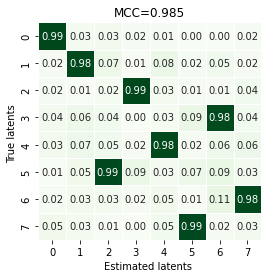

In [213]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages(figure_path + '/mcc_np.pdf') as pdf:

    fig = plt.figure(figsize=(4,4))
    sns.heatmap(-C, vmin=0, vmax=1, annot=True, fmt=".2f", linewidths=.5, cbar=False, cmap='Greens')
    plt.xlabel("Estimated latents ") 
    plt.ylabel("True latents ") 
    plt.title("MCC=%.3f"%np.abs(C[row_ind, col_ind]).mean());
    pdf.savefig(fig, bbox_inches="tight")

In [12]:
from leap.modules.components.pruning import LassoNetRegressor, plot_path

In [68]:
pr_model = LassoNetRegressor(
    hidden_dims=(16,8),
    eps_start=0.1,
    verbose=True,
    device='cpu'
)

In [69]:
z0 = mu[:,0,:].detach().cpu().numpy()[:, col_ind]
z1 = mu[:,1,:].detach().cpu().numpy()[:, col_ind]
z2 = mu[:,2,:].detach().cpu().numpy()[:, col_ind]

In [189]:
X = np.concatenate((z0,z1),axis=1)
Y = z2

In [191]:
path = pr_model.path(X, Y[:,1])

Initialized dense model in 1000 epochs, val loss 3.78e-03, regularization 2.68e-01
Lambda = 3.78e-04, selected 16 features in 75 epochs
val_objective 3.53e-03, val_loss 3.43e-03, regularization 2.68e-01
Lambda = 3.85e-04, selected 16 features in 10 epochs
val_objective 3.50e-03, val_loss 3.40e-03, regularization 2.68e-01
Lambda = 3.93e-04, selected 16 features in 10 epochs
val_objective 3.47e-03, val_loss 3.37e-03, regularization 2.68e-01
Lambda = 4.01e-04, selected 16 features in 10 epochs
val_objective 3.45e-03, val_loss 3.34e-03, regularization 2.68e-01
Lambda = 4.09e-04, selected 16 features in 10 epochs
val_objective 3.43e-03, val_loss 3.32e-03, regularization 2.68e-01
Lambda = 4.17e-04, selected 16 features in 10 epochs
val_objective 3.42e-03, val_loss 3.31e-03, regularization 2.69e-01
Lambda = 4.25e-04, selected 16 features in 10 epochs
val_objective 3.40e-03, val_loss 3.29e-03, regularization 2.69e-01
Lambda = 4.34e-04, selected 16 features in 10 epochs
val_objective 3.39e-03, 

Lambda = 1.60e-03, selected 16 features in 10 epochs
val_objective 3.51e-03, val_loss 3.09e-03, regularization 2.60e-01
Lambda = 1.64e-03, selected 16 features in 10 epochs
val_objective 3.51e-03, val_loss 3.09e-03, regularization 2.60e-01
Lambda = 1.67e-03, selected 16 features in 10 epochs
val_objective 3.52e-03, val_loss 3.09e-03, regularization 2.60e-01
Lambda = 1.70e-03, selected 16 features in 10 epochs
val_objective 3.53e-03, val_loss 3.09e-03, regularization 2.59e-01
Lambda = 1.74e-03, selected 16 features in 10 epochs
val_objective 3.54e-03, val_loss 3.09e-03, regularization 2.59e-01
Lambda = 1.77e-03, selected 16 features in 10 epochs
val_objective 3.54e-03, val_loss 3.09e-03, regularization 2.59e-01
Lambda = 1.81e-03, selected 16 features in 10 epochs
val_objective 3.55e-03, val_loss 3.09e-03, regularization 2.59e-01
Lambda = 1.84e-03, selected 16 features in 10 epochs
val_objective 3.56e-03, val_loss 3.09e-03, regularization 2.58e-01
Lambda = 1.88e-03, selected 16 features 

Lambda = 6.54e-03, selected 16 features in 10 epochs
val_objective 4.59e-03, val_loss 3.05e-03, regularization 2.35e-01
Lambda = 6.67e-03, selected 16 features in 10 epochs
val_objective 4.62e-03, val_loss 3.05e-03, regularization 2.35e-01
Lambda = 6.80e-03, selected 16 features in 10 epochs
val_objective 4.65e-03, val_loss 3.05e-03, regularization 2.34e-01
Lambda = 6.94e-03, selected 16 features in 10 epochs
val_objective 4.67e-03, val_loss 3.05e-03, regularization 2.34e-01
Lambda = 7.08e-03, selected 16 features in 10 epochs
val_objective 4.70e-03, val_loss 3.05e-03, regularization 2.33e-01
Lambda = 7.22e-03, selected 16 features in 10 epochs
val_objective 4.73e-03, val_loss 3.05e-03, regularization 2.33e-01
Lambda = 7.36e-03, selected 16 features in 10 epochs
val_objective 4.76e-03, val_loss 3.05e-03, regularization 2.32e-01
Lambda = 7.51e-03, selected 16 features in 10 epochs
val_objective 4.79e-03, val_loss 3.05e-03, regularization 2.32e-01
Lambda = 7.66e-03, selected 16 features 

Lambda = 2.72e-02, selected 16 features in 10 epochs
val_objective 7.69e-03, val_loss 3.03e-03, regularization 1.71e-01
Lambda = 2.78e-02, selected 16 features in 10 epochs
val_objective 7.74e-03, val_loss 3.03e-03, regularization 1.70e-01
Lambda = 2.83e-02, selected 16 features in 10 epochs
val_objective 7.79e-03, val_loss 3.03e-03, regularization 1.68e-01
Lambda = 2.89e-02, selected 16 features in 10 epochs
val_objective 7.83e-03, val_loss 3.03e-03, regularization 1.66e-01
Lambda = 2.95e-02, selected 16 features in 10 epochs
val_objective 7.88e-03, val_loss 3.03e-03, regularization 1.65e-01
Lambda = 3.00e-02, selected 16 features in 10 epochs
val_objective 7.92e-03, val_loss 3.03e-03, regularization 1.63e-01
Lambda = 3.06e-02, selected 16 features in 10 epochs
val_objective 7.96e-03, val_loss 3.03e-03, regularization 1.61e-01
Lambda = 3.13e-02, selected 16 features in 10 epochs
val_objective 8.00e-03, val_loss 3.02e-03, regularization 1.59e-01
Lambda = 3.19e-02, selected 16 features 

Lambda = 1.20e-01, selected 16 features in 10 epochs
val_objective 7.62e-03, val_loss 3.00e-03, regularization 3.84e-02
Lambda = 1.23e-01, selected 16 features in 10 epochs
val_objective 7.71e-03, val_loss 3.00e-03, regularization 3.84e-02
Lambda = 1.25e-01, selected 16 features in 10 epochs
val_objective 7.80e-03, val_loss 3.00e-03, regularization 3.84e-02
Lambda = 1.28e-01, selected 16 features in 10 epochs
val_objective 7.89e-03, val_loss 3.00e-03, regularization 3.84e-02
Lambda = 1.30e-01, selected 16 features in 10 epochs
val_objective 7.99e-03, val_loss 3.00e-03, regularization 3.83e-02
Lambda = 1.33e-01, selected 16 features in 10 epochs
val_objective 8.08e-03, val_loss 3.00e-03, regularization 3.83e-02
Lambda = 1.35e-01, selected 16 features in 10 epochs
val_objective 8.18e-03, val_loss 3.00e-03, regularization 3.83e-02
Lambda = 1.38e-01, selected 16 features in 10 epochs
val_objective 8.28e-03, val_loss 3.00e-03, regularization 3.83e-02
Lambda = 1.41e-01, selected 16 features 

Lambda = 5.00e-01, selected 16 features in 10 epochs
val_objective 2.06e-02, val_loss 3.02e-03, regularization 3.52e-02
Lambda = 5.10e-01, selected 16 features in 10 epochs
val_objective 2.09e-02, val_loss 3.02e-03, regularization 3.51e-02
Lambda = 5.20e-01, selected 16 features in 10 epochs
val_objective 2.12e-02, val_loss 3.02e-03, regularization 3.50e-02
Lambda = 5.31e-01, selected 16 features in 10 epochs
val_objective 2.16e-02, val_loss 3.03e-03, regularization 3.49e-02
Lambda = 5.41e-01, selected 16 features in 10 epochs
val_objective 2.19e-02, val_loss 3.03e-03, regularization 3.49e-02
Lambda = 5.52e-01, selected 16 features in 10 epochs
val_objective 2.22e-02, val_loss 3.03e-03, regularization 3.48e-02
Lambda = 5.63e-01, selected 16 features in 10 epochs
val_objective 2.26e-02, val_loss 3.03e-03, regularization 3.47e-02
Lambda = 5.74e-01, selected 16 features in 10 epochs
val_objective 2.29e-02, val_loss 3.03e-03, regularization 3.46e-02
Lambda = 5.86e-01, selected 16 features 

Lambda = 2.04e+00, selected 14 features in 10 epochs
val_objective 5.51e-02, val_loss 3.50e-03, regularization 2.53e-02
Lambda = 2.08e+00, selected 14 features in 10 epochs
val_objective 5.57e-02, val_loss 3.52e-03, regularization 2.51e-02
Lambda = 2.12e+00, selected 14 features in 10 epochs
val_objective 5.64e-02, val_loss 3.53e-03, regularization 2.49e-02
Lambda = 2.16e+00, selected 14 features in 10 epochs
val_objective 5.71e-02, val_loss 3.54e-03, regularization 2.47e-02
Lambda = 2.21e+00, selected 14 features in 10 epochs
val_objective 5.78e-02, val_loss 3.55e-03, regularization 2.46e-02
Lambda = 2.25e+00, selected 14 features in 10 epochs
val_objective 5.85e-02, val_loss 3.56e-03, regularization 2.44e-02
Lambda = 2.30e+00, selected 14 features in 10 epochs
val_objective 5.94e-02, val_loss 3.57e-03, regularization 2.43e-02
Lambda = 2.34e+00, selected 14 features in 10 epochs
val_objective 6.02e-02, val_loss 3.57e-03, regularization 2.42e-02
Lambda = 2.39e+00, selected 14 features 

Lambda = 9.19e+00, selected 7 features in 10 epochs
val_objective 1.23e-01, val_loss 4.88e-03, regularization 1.29e-02
Lambda = 9.37e+00, selected 7 features in 10 epochs
val_objective 1.25e-01, val_loss 4.89e-03, regularization 1.28e-02
Lambda = 9.56e+00, selected 7 features in 10 epochs
val_objective 1.26e-01, val_loss 4.90e-03, regularization 1.27e-02
Lambda = 9.75e+00, selected 7 features in 10 epochs
val_objective 1.27e-01, val_loss 4.91e-03, regularization 1.25e-02
Lambda = 9.95e+00, selected 7 features in 10 epochs
val_objective 1.29e-01, val_loss 4.92e-03, regularization 1.24e-02
Lambda = 1.01e+01, selected 7 features in 10 epochs
val_objective 1.30e-01, val_loss 4.92e-03, regularization 1.23e-02
Lambda = 1.03e+01, selected 7 features in 10 epochs
val_objective 1.32e-01, val_loss 4.92e-03, regularization 1.23e-02
Lambda = 1.06e+01, selected 7 features in 10 epochs
val_objective 1.33e-01, val_loss 4.92e-03, regularization 1.22e-02
Lambda = 1.08e+01, selected 7 features in 10 epo

Lambda = 3.60e+01, selected 7 features in 20 epochs
val_objective 1.93e-01, val_loss 1.01e-02, regularization 5.08e-03
Lambda = 3.67e+01, selected 7 features in 10 epochs
val_objective 1.95e-01, val_loss 1.02e-02, regularization 5.02e-03
Lambda = 3.75e+01, selected 7 features in 57 epochs
val_objective 1.77e-01, val_loss 1.01e-02, regularization 4.46e-03
Lambda = 3.82e+01, selected 7 features in 10 epochs
val_objective 1.80e-01, val_loss 1.02e-02, regularization 4.43e-03
Lambda = 3.90e+01, selected 7 features in 10 epochs
val_objective 1.82e-01, val_loss 1.03e-02, regularization 4.40e-03
Lambda = 3.98e+01, selected 7 features in 10 epochs
val_objective 1.84e-01, val_loss 1.04e-02, regularization 4.36e-03
Lambda = 4.06e+01, selected 7 features in 10 epochs
val_objective 1.86e-01, val_loss 1.05e-02, regularization 4.32e-03
Lambda = 4.14e+01, selected 7 features in 10 epochs
val_objective 1.88e-01, val_loss 1.06e-02, regularization 4.29e-03
Lambda = 4.22e+01, selected 7 features in 10 epo

Lambda = 1.59e+02, selected 6 features in 10 epochs
val_objective 4.84e-01, val_loss 1.96e-02, regularization 2.92e-03
Lambda = 1.62e+02, selected 6 features in 10 epochs
val_objective 4.91e-01, val_loss 1.98e-02, regularization 2.90e-03
Lambda = 1.66e+02, selected 6 features in 10 epochs
val_objective 4.98e-01, val_loss 2.00e-02, regularization 2.89e-03
Lambda = 1.69e+02, selected 6 features in 10 epochs
val_objective 5.05e-01, val_loss 2.02e-02, regularization 2.87e-03
Lambda = 1.72e+02, selected 6 features in 10 epochs
val_objective 5.13e-01, val_loss 2.04e-02, regularization 2.86e-03
Lambda = 1.76e+02, selected 6 features in 13 epochs
val_objective 5.21e-01, val_loss 2.05e-02, regularization 2.85e-03
Lambda = 1.79e+02, selected 6 features in 13 epochs
val_objective 5.29e-01, val_loss 2.07e-02, regularization 2.84e-03
Lambda = 1.83e+02, selected 6 features in 12 epochs
val_objective 5.35e-01, val_loss 2.10e-02, regularization 2.81e-03
Lambda = 1.86e+02, selected 6 features in 13 epo

Lambda = 6.49e+02, selected 6 features in 13 epochs
val_objective 1.03e+00, val_loss 6.40e-02, regularization 1.49e-03
Lambda = 6.62e+02, selected 6 features in 12 epochs
val_objective 1.04e+00, val_loss 6.44e-02, regularization 1.48e-03
Lambda = 6.75e+02, selected 6 features in 13 epochs
val_objective 1.04e+00, val_loss 6.68e-02, regularization 1.44e-03
Lambda = 6.89e+02, selected 6 features in 13 epochs
val_objective 1.03e+00, val_loss 6.89e-02, regularization 1.40e-03
Lambda = 7.03e+02, selected 6 features in 12 epochs
val_objective 1.04e+00, val_loss 6.98e-02, regularization 1.39e-03
Lambda = 7.17e+02, selected 6 features in 13 epochs
val_objective 1.04e+00, val_loss 7.26e-02, regularization 1.35e-03
Lambda = 7.31e+02, selected 6 features in 12 epochs
val_objective 1.04e+00, val_loss 7.36e-02, regularization 1.33e-03
Lambda = 7.46e+02, selected 5 features in 12 epochs
val_objective 1.05e+00, val_loss 7.51e-02, regularization 1.31e-03
Lambda = 7.60e+02, selected 6 features in 12 epo

In [39]:
pr_model = pr_model.load(path[500])

In [193]:
W2.T!=0

array([[ True, False, False, False,  True,  True, False, False],
       [ True,  True, False, False, False, False,  True, False],
       [ True,  True,  True, False,  True,  True,  True, False],
       [False,  True, False,  True,  True, False, False,  True],
       [False,  True, False,  True,  True,  True,  True, False],
       [False, False, False, False,  True,  True, False, False],
       [False, False,  True,  True, False, False,  True,  True],
       [ True, False,  True,  True, False,  True,  True,  True]])

In [92]:
W1.T!=0

array([[ True,  True,  True, False, False, False,  True, False],
       [False,  True,  True, False,  True, False,  True, False],
       [False, False,  True, False, False,  True, False,  True],
       [ True, False, False,  True,  True,  True, False,  True],
       [ True, False, False,  True,  True, False, False, False],
       [False, False,  True, False, False,  True, False,  True],
       [False, False, False,  True, False,  True,  True, False],
       [ True, False, False, False,  True, False,  True,  True]])

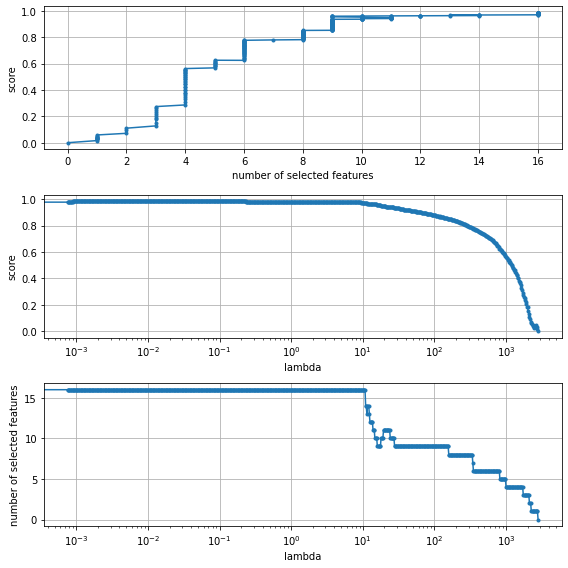

In [73]:
plot_path(pr_model, path, X, Y[:,0])

In [26]:
from torch.autograd.functional import jacobian
def compute_masked_jacobian(x, masks, gs, L):
    def masked_forward(mask, xxi, yy):
        inputs = torch.cat((yy*mask, xxi),dim=-1)
        return gs[i](inputs)
    batch_size, length, input_dim = x.shape
    x = x.unfold(dimension = 1, size = L+1, step = 1)
    x = torch.swapaxes(x, 2, 3)
    shape = x.shape
    x = x.reshape(-1, L+1, input_dim)
    xx, yy = x[:,-1:], x[:,:-1]
    yy = yy.reshape(-1, L*input_dim)
    pdds = [ ]
    for i in range(input_dim):
#         xxi = xx[:,:,i]
        mask = masks[i]
        # Redefine input function
        inputs = torch.cat((yy*mask, xx[:,:,i]),dim=-1)
        residual = gs[i](inputs)
        with torch.enable_grad():
            pdd = jacobian(gs[i], inputs, create_graph=True, vectorize=True)
#             pdd = jacobian(masked_forward, (mask, xxi, yy), create_graph=True, vectorize=True)
            pdds.append(pdd[2])
    return torch.stack(pdds, 0).squeeze()

In [13]:
pdds = compute_masked_jacobian(z.detach(), torch.sigmoid(model.logits).detach(), model.transition_prior.gs, 2)

> /tmp/ipykernel_2908/1649900619.py(24)compute_masked_jacobian()
     23             pdb.set_trace()
---> 24             pdds.append(pdd[2])
     25     return torch.stack(pdds, 0).squeeze()

ipdb> pdd[2]
tensor([[[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [ 22.3987, -44.9978, -33.0270,  ...,  37.6301,  73.7455,  45.4146],
         ...,
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]]],
       grad_fn=<SelectBackward>)
ipdb> pdd[2].shape
torch.Size([1, 512, 17])
ipdb> pdd[2][0:,0]
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       grad_fn=<SelectBackward>)
ipdb> pdd[2][0,:,0]
tensor([ 0.0000,  0.0000, 22.3987,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         

ipdb> pdd.shape
torch.Size([512, 1, 512, 17])
ipdb> torch.diag(pdd[:,0,:,-1])
tensor([  21.7121,  366.4467,   45.4146,  291.4435,   18.5643,   18.0262,
         619.2397,   18.2988,  621.3915,  622.4697,   22.5618,  624.9552,
          18.7315,  131.1493,   18.0263,  630.3116,  620.2180,  261.6540,
         722.9315,  663.9261,  164.9251,   18.0262,  605.3912,   18.0261,
          17.3697,   17.3697,   17.3697,   17.3697,  724.1057,  660.1440,
         722.9315,   65.2541,   18.3769,  111.4160,   18.0262,  619.3035,
          18.0263,  623.4493,  435.2285,   18.0275,  663.9261,   65.2541,
          17.3697,   17.3697,   65.2541,   17.3698,   17.3697,   17.3697,
         658.8304,   18.0862,   19.5751,  262.5320,   18.0268,   20.7317,
          18.0354,  107.8331,   32.7469,   18.0770,   18.0261,   18.0261,
         623.2947,  659.1577,  555.2134,  272.6410,  294.0688,   18.0572,
          18.3178,   18.2584,   18.0792,   62.1108,   43.7159,   18.0263,
         397.8234,  662.1900,  394

BdbQuit: 

In [572]:
X_aux = np.concatenate((X,np.random.randn(25600,1)), axis=1)
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()
clf.fit(X_aux, Y[:,-1])
((clf.feature_importances_ >= clf.feature_importances_[-1] + 0.01)[:-1]) == ((np.concatenate((W2,W1),axis=0)[:,0])!=0)
clf.feature_importances_

RandomForestRegressor()

In [66]:
z0 = mu[:,0,:].detach().cpu().numpy()[:, col_ind]
z1 = mu[:,1,:].detach().cpu().numpy()[:, col_ind]
z2 = mu[:,2,:].detach().cpu().numpy()[:, col_ind]

In [179]:
z0 = batch['s1']['yt'][:,0,:].detach().cpu().numpy()
z1 = batch['s1']['yt'][:,1,:].detach().cpu().numpy()
z2 = batch['s1']['yt'][:,2,:].detach().cpu().numpy()

In [180]:
X = np.concatenate((z0,z1),axis=1)
X = z0
Y = z2

In [181]:
from sklearn.feature_selection import mutual_info_regression

In [185]:
accuracies = [ ]
mask = [ ]
thres = 0.025
n_neighbors = 10
for idx in range(8):
    mi = mutual_info_regression(X, Y[:,idx], n_neighbors=n_neighbors)
    mask = mask + list((mi / np.max(mi)) > thres)
    accuracies = accuracies + list(((mi / np.max(mi)) > thres) == (W2[:,idx]!=0))
print(np.mean(accuracies))

0.921875


In [54]:
accuracies = [ ]
mask = [ ]
thres = 0.085
n_neighbors = 10
for idx in range(8):
    mi = mutual_info_regression(X, Y[:,idx], n_neighbors=n_neighbors)
    mask = mask + list((mi / np.max(mi)) > thres)
#     accuracies = accuracies + list(((mi / np.max(mi)) > thres) == ((np.concatenate((W2,W1),axis=0)[:,idx])!=0))
print(np.mean(accuracies))

nan


/home/weiran/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/weiran/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [34]:
list(((mi / np.max(mi)) > thres) == ((np.concatenate((W2,W1),axis=0)[:,idx])!=0))

/tmp/ipykernel_19974/3627211018.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  list(((mi / np.max(mi)) > thres) == ((np.concatenate((W2,W1),axis=0)[:,idx])!=0))


TypeError: 'bool' object is not iterable

In [40]:
((mi / np.max(mi)) > thres) == ((np.concatenate((W2,W1),axis=0)[:,idx])!=0)

/tmp/ipykernel_19974/58818163.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  ((mi / np.max(mi)) > thres) == ((np.concatenate((W2,W1),axis=0)[:,idx])!=0)


False

In [38]:
((np.concatenate((W2,W1),axis=0)[:,idx])!=0)

array([ True, False, False, False,  True,  True, False, False,  True,
        True,  True, False, False, False,  True, False])

In [36]:
mi / np.max(mi) > thres

array([ True, False, False, False,  True,  True, False, False])

In [186]:
mask = np.array(mask).reshape(8,8)
for i in range(8):
    mask[i,i] = 1

<AxesSubplot:>

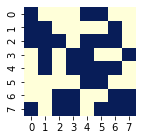

In [195]:
fig = plt.figure(figsize=(2,2))
sns.heatmap(W2.T!=0, cmap="YlGnBu", cbar=False)

<AxesSubplot:>

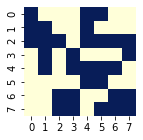

In [196]:
fig = plt.figure(figsize=(2,2))
sns.heatmap(mask, cmap="YlGnBu", cbar=False)

<AxesSubplot:>

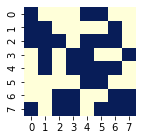

In [55]:
fig = plt.figure(figsize=(2,2))
sns.heatmap(W2.T!=0, cmap="YlGnBu", cbar=False)

<AxesSubplot:>

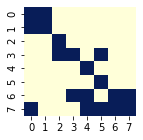

In [154]:
fig = plt.figure(figsize=(2,2))
sns.heatmap(mask, cmap="YlGnBu", cbar=False)

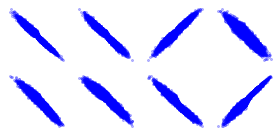

In [197]:
fig, axs = plt.subplots(2,4, figsize=(4,2))
for i in range(8):
    row = i // 4
    col = i % 4
    ax = axs[row,col]
    ax.scatter(B[:,i], A[:,i], s=4, color='b', alpha=0.25)
    ax.axis('off')
#     ax.set_xlabel('Ground truth latent')
#     ax.set_ylabel('Estimated latent')
#     ax.grid('..')
fig.tight_layout()

In [47]:
W1 = np.load('/srv/data/ltcl/data/nonlinear_gau_cins_sparse/W1.npy')
W2 = np.load('/srv/data/ltcl/data/nonlinear_gau_cins_sparse/W2.npy')

In [295]:
weights = np.abs(F.sigmoid(model.logits).detach().cpu().numpy())

/home/weiran/anaconda3/envs/ltcl/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [155]:
import h5py

In [2]:
file = h5py.File('/srv/data/ltcl/data/physics_ball_5_s1_Ball/raw/0.h5', 'r')
states = file['states'][:]

NameError: name 'h5py' is not defined

In [258]:
from sklearn.linear_model import LinearRegression

In [263]:
X = data[:-1,0,[0,2]]
y = data[1:,0,0]

In [264]:
model = LinearRegression().fit(X,y)

In [267]:
model.coef_

array([1.  , 0.02])

In [252]:
data = states[:-1].copy()
data[:,:,2:] =states[1:,:,2:]
# data = data.reshape(99, -1)